In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
np.random.seed(1234)

from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.utils.vis_utils import plot_model
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV,KFold

In [2]:
# use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## File processing

In [3]:
directory = "../datasets/Dataset for CA1 part A/Dataset for CA1 part A"

In [40]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
# Load train data
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/train',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# Load validation data
validation_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/validation',
                                                                 shuffle=True,    
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Load test data
test_dataset = tf.keras.utils.image_dataset_from_directory(directory=f'{directory}/test',
                                                                 shuffle=True,    
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)                                                                 

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [41]:
# List vegetable classes
class_names = train_dataset.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [42]:
# Print total no. of training batches
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())

Number of training batches: 283


## EDA

In [43]:
# Split datasets 
X_train = []
y_train = []

for images, labels in train_dataset:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for images, labels in test_dataset:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)


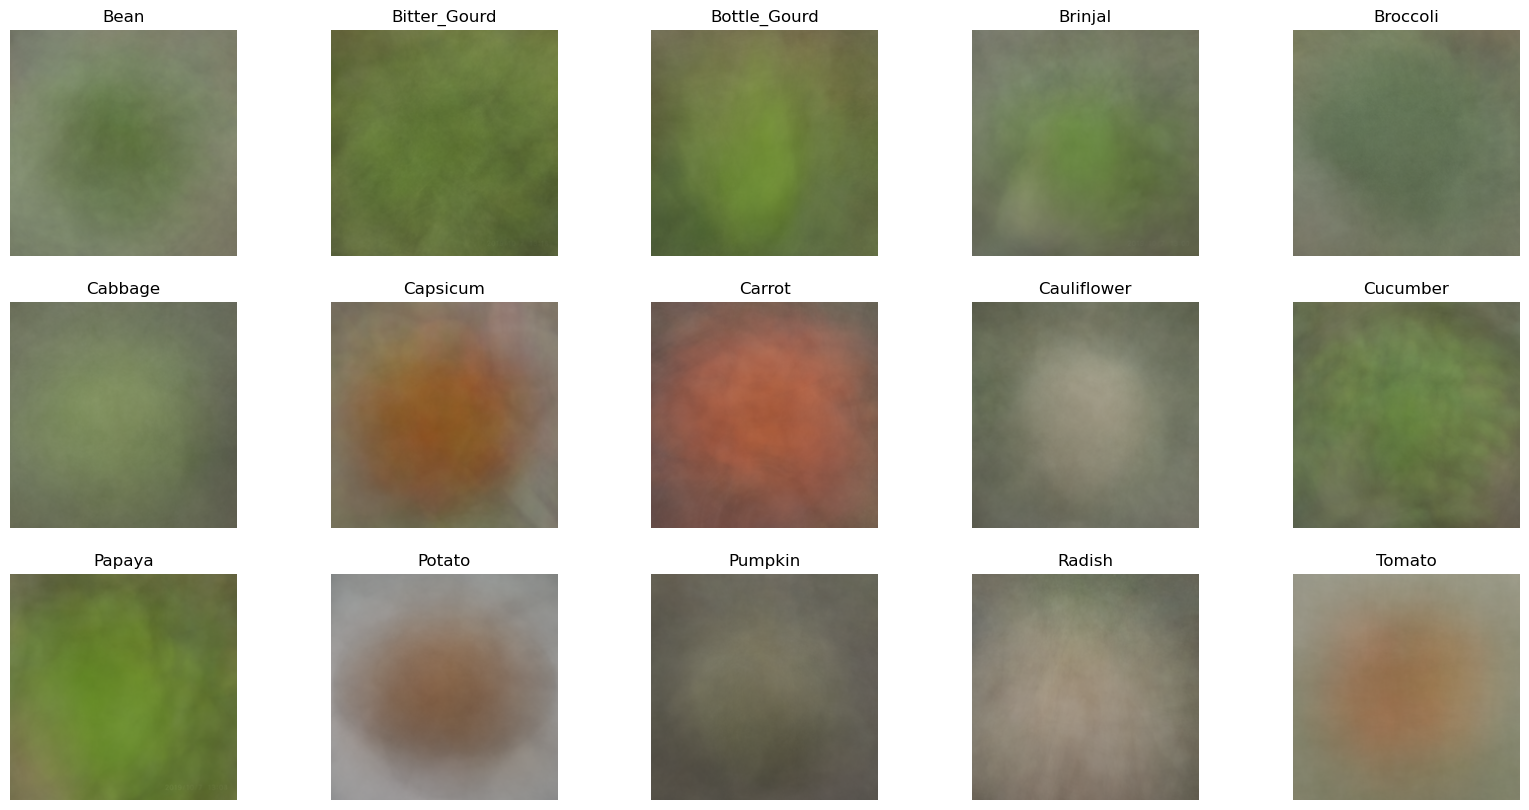

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5, figsize=(20, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(X_train[np.squeeze(y_train == idx)], axis=0) / 255
    subplot.imshow(avg_image, cmap="Greys")
    subplot.set_title(f"{class_names[idx]}")
    subplot.axis("off")

In [45]:
# Find value counts
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print(f"{class_names[label]}: {count}")

Bean: 780
Bitter_Gourd: 720
Bottle_Gourd: 441
Brinjal: 868
Broccoli: 750
Cabbage: 503
Capsicum: 351
Carrot: 256
Cauliflower: 587
Cucumber: 812
Papaya: 566
Potato: 377
Pumpkin: 814
Radish: 248
Tomato: 955


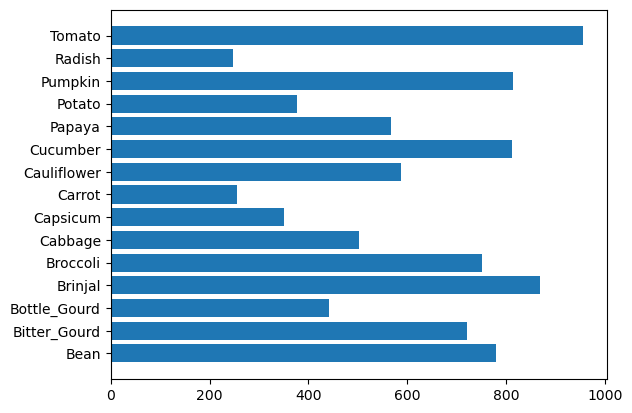

In [46]:
# Plot value counts
plt.barh(labels, counts, tick_label=list(class_names))
plt.show()


Radishes, Potatoes, Carrots, Capsicums, Cabbages, Papayas and Bottle Gourds are especially undersampled, perform augmentation to get more of such images

In [47]:
# Map iamge to label
train_dict = {tf.Tensor.ref(img): label for img, label in train_dataset.unbatch()}

In [48]:
# Subset undersampled classes
radishes = [img for img, label in train_dict.items() if label == 13]
radish_labels = [label for img, label in train_dict.items() if label == 13]


potatoes = [img for img, label in train_dict.items() if label == 11]
potato_labels = [label for img, label in train_dict.items() if label == 11]
carrots = [img for img, label in train_dict.items() if label == 7]
carrot_labels = [label for img, label in train_dict.items() if label == 7]
capsicums = [img for img, label in train_dict.items() if label == 6]
capsicum_labels = [label for img, label in train_dict.items() if label == 6]
cabbages = [img for img, label in train_dict.items() if label == 5]
cabbage_labels = [label for img, label in train_dict.items() if label == 5]
papayas = [img for img, label in train_dict.items() if label == 10]
papaya_labels = [label for img, label in train_dict.items() if label == 10]
bottle_gourds = [img for img, label in train_dict.items() if label == 2]
bottle_gourd_labels = [label for img, label in train_dict.items() if label == 2]

In [49]:
radishes = [radish.deref() for radish in radishes]
potatoes = [potato.deref() for potato in potatoes]
carrots = [carrot.deref() for carrot in carrots]
capsicums = [capsicum.deref() for capsicum in capsicums]
cabbages = [cabbage.deref() for cabbage in cabbages]
papayas = [papaya.deref() for papaya in papayas]
bottle_gourds = [bottle_gourd.deref() for bottle_gourd in bottle_gourds]

In [50]:
undersampled_vegs = np.concatenate((radishes, potatoes, carrots, capsicums, cabbages, papayas, bottle_gourds), axis=0)
undersampled_labels = np.concatenate((radish_labels, potato_labels, carrot_labels, capsicum_labels, cabbage_labels, papaya_labels, bottle_gourd_labels))
def data_augmentation(data):
    imageArr = []
    for images in data:
        image = tf.image.random_flip_left_right(images)
        image = tf.image.random_crop(
            image, size=(224,224,3)
        )
        imageArr.append(tf.reshape(image, (224, 224, 3)))
    return np.array(imageArr)
veg_train_aug = np.copy(undersampled_vegs)
veg_train_aug = data_augmentation(veg_train_aug)

In [51]:
X_train_aug = np.concatenate((X_train , veg_train_aug), axis=0)
y_train_aug = np.concatenate((y_train, undersampled_labels), axis=0)

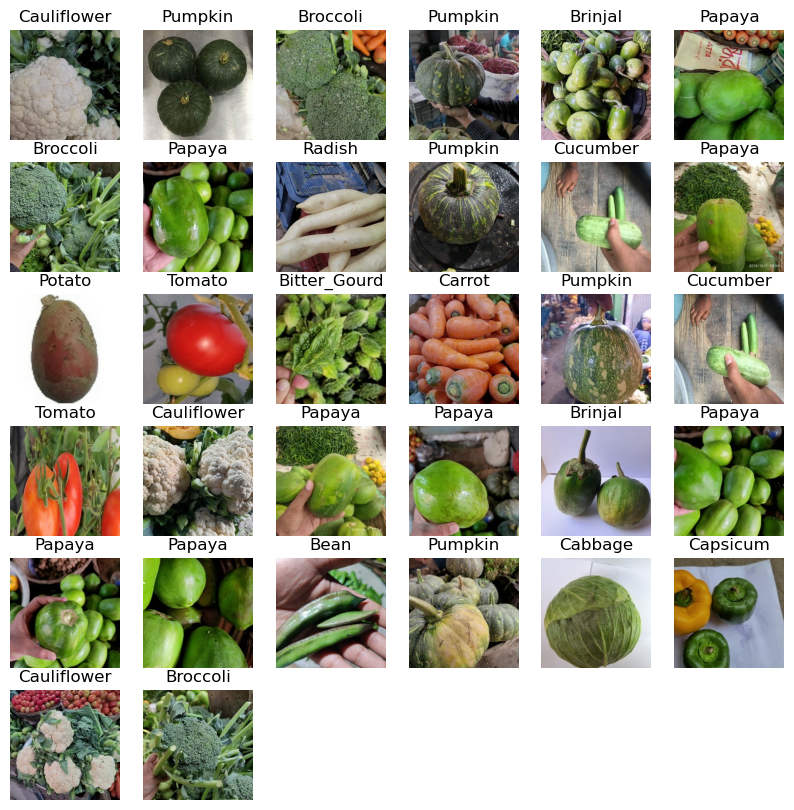

In [52]:
# Show sample images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

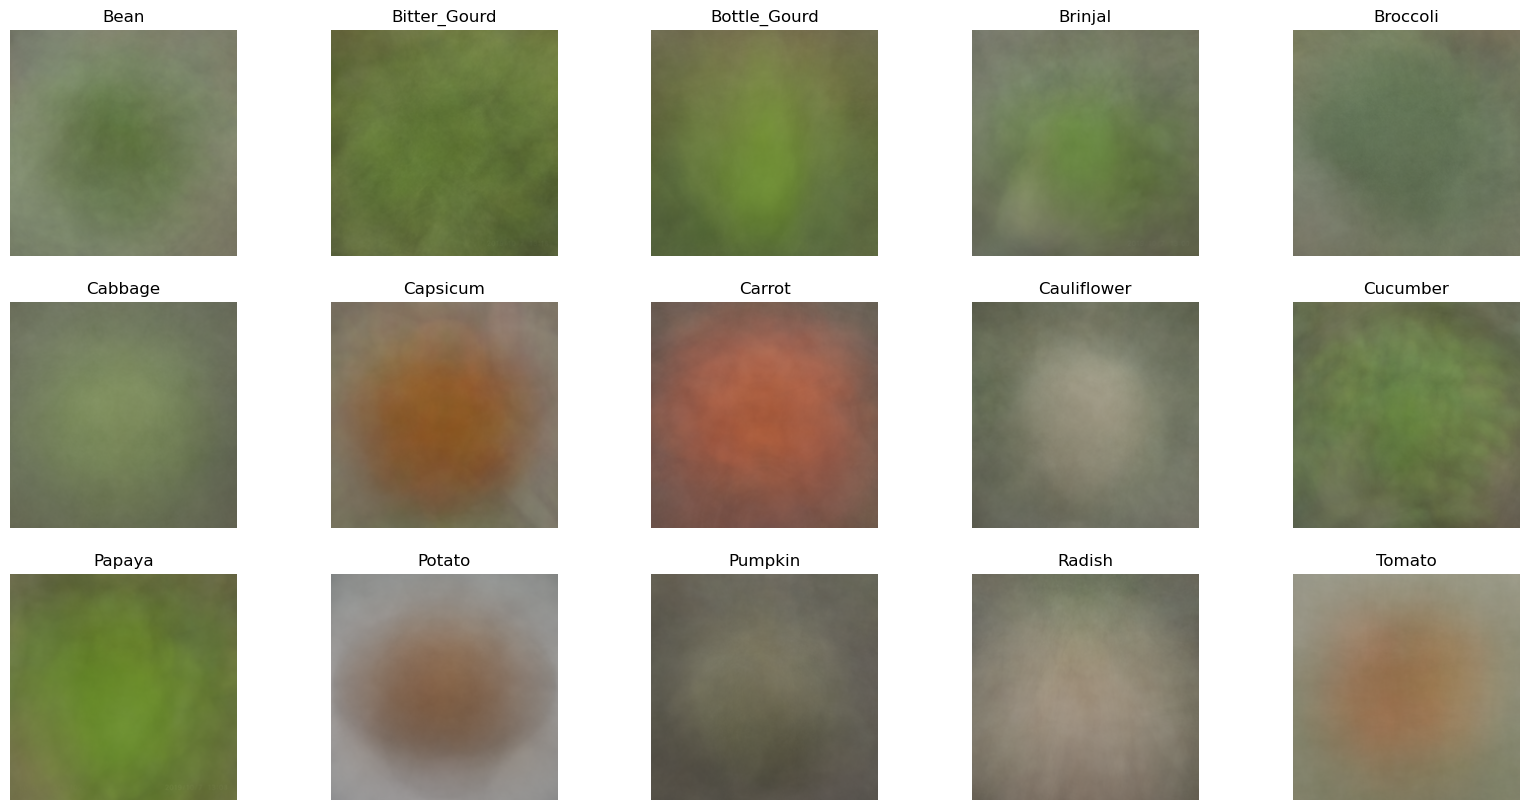

In [53]:
# Pixel averaging after augmentation
fig, ax = plt.subplots(3, 5, figsize=(20, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(X_train_aug[np.squeeze(y_train_aug == idx)], axis=0) / 255
    subplot.imshow(avg_image, cmap="Greys")
    subplot.set_title(f"{class_names[idx]}")
    subplot.axis("off")

In [54]:
# Define a function to convert an RGB image to grayscale
def rgb_to_grayscale(image, label):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

def rgb_to_grayscale2(img):
    img = tf.image.rgb_to_grayscale(img)
    return img

# Apply the grayscale conversion function to the dataset
# grayscale_train_dataset = X_train_aug.map(rgb_to_grayscale)
# grayscale_test_dataset = test_dataset.map(rgb_to_grayscale)
grayscale_validation_dataset = validation_dataset.map(rgb_to_grayscale)
grayscale_test_dataset = rgb_to_grayscale2(X_test)
X_train_aug = rgb_to_grayscale2(X_train_aug)

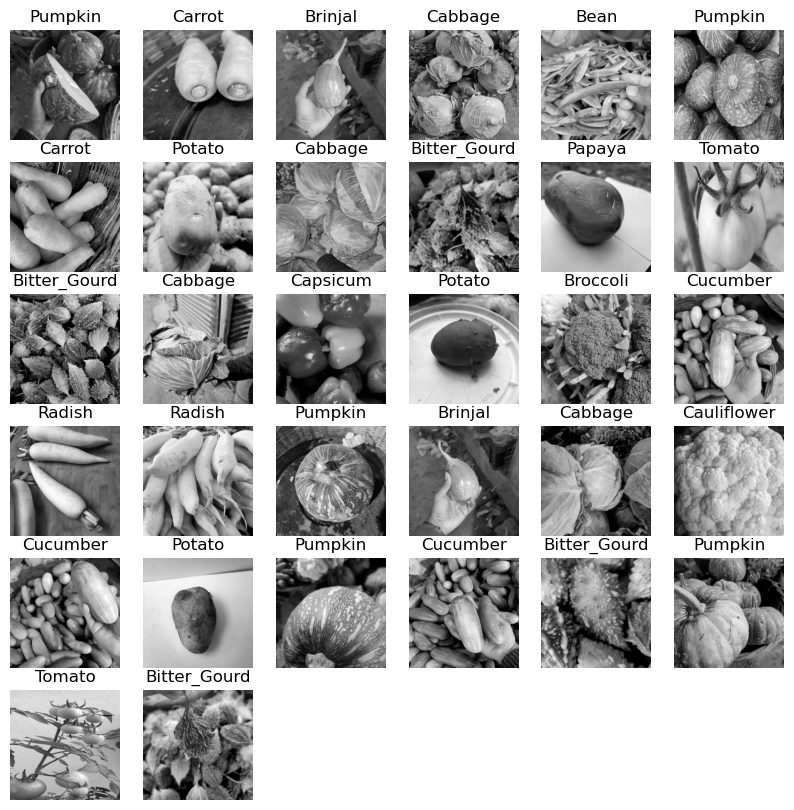

In [55]:
import matplotlib.pyplot as plt
# Show greyscaled images
plt.figure(figsize=(10, 10))
for images, labels in grayscale_validation_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [56]:
# Resize image into 31x31 images
NEW_IMG_SIZE = (31, 31)
AUTO = tf.data.AUTOTUNE

def preprocess_dataset(image, label):
    # scale = tf.keras.layers.Rescaling(1./255)
    # image = scale(image)
    image = tf.image.resize(image, NEW_IMG_SIZE)
    label = label
    return (image, label)

# processed_train_dataset = (
#     grayscale_train_dataset
#     .map(preprocess_dataset, num_parallel_calls=AUTO)
# )

processed_validation_dataset = (
    grayscale_validation_dataset
    .map(preprocess_dataset, num_parallel_calls=AUTO)
)

# processed_test_dataset = (
#     grayscale_test_dataset
#     .map(preprocess_dataset, num_parallel_calls=AUTO)
# )

In [57]:
def resize(img):
    # scale = tf.keras.layers.Rescaling(1./255)
    # img = scale(img)
    img = tf.image.resize(img, NEW_IMG_SIZE)
    return img

X_train_aug = resize(X_train_aug)
X_test = resize(grayscale_test_dataset)

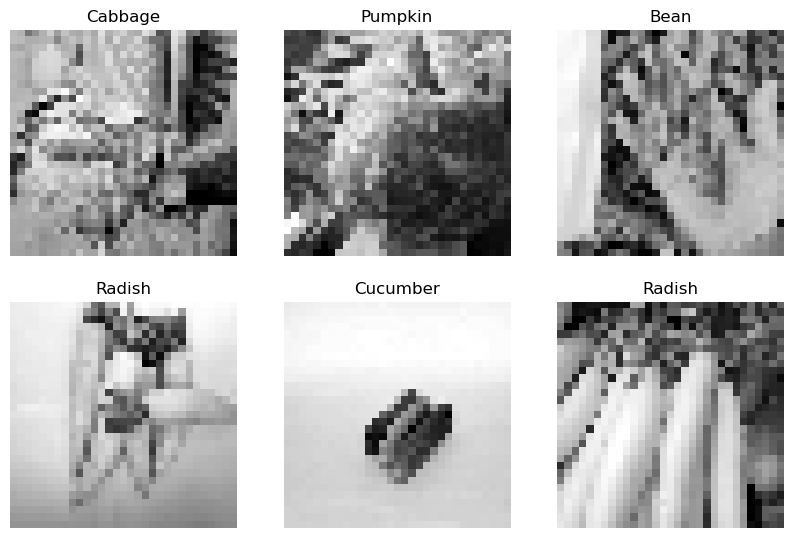

In [58]:
# Show resized images
plt.figure(figsize=(10, 10))
for images, labels in processed_validation_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [59]:
# def rescale(image, label):
#     scale = tf.keras.layers.Rescaling(1./255)
#     image = scale(image)
#     label = label
#     return image, label

# def rescale2(img):
#     scale = tf.keras.layers.Rescaling(1./255)
#     img = scale(img)
#     return img

# X_train_aug_rescaled = rescale2(X_train_aug)
# processed_validation_dataset_rescaled = processed_validation_dataset.map(rescale)
# processed_test_dataset_rescaled = processed_test_dataset.map(rescale)

## Model Improvements

In [60]:
epochs = 50

Optimising batchsize

In [ ]:
# Run parametric experiment to tune dropout percentage
def createAndTrain_model_BatchSize(batchsize):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(31, 31, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train_aug, y_train_aug, validation_data=processed_validation_dataset, epochs=epochs, batch_size=batchsize, shuffle=True)

    # Evaluate model on unseen data
    scores = model.evaluate(X_test, y_test)
    testError = 100-scores[1]*100

    return history, scores[1], testError

In [ ]:
# range of batch sizes
batchsizes = 2**np.arange(4, 9)

# initialize output results matrices
accuracyResultsTrain = np.zeros((epochs, len(batchsizes)))
accuracyResultsVal = np.zeros((epochs, len(batchsizes)))
accuracyResultsTest  = np.zeros((epochs, len(batchsizes)))

# loop over batch sizes
for bi in range(len(batchsizes)):
    history, score, testError = createAndTrain_model_BatchSize(batchsizes[bi])

    # store results
    accuracyResultsTrain[:,bi] = history.history['accuracy']
    accuracyResultsVal[:,bi] = history.history['val_accuracy']
    accuracyResultsTest[:,bi] = score

Epoch 1/50
736/736 [==============================] - 8s 10ms/step - loss: 2.1072 - accuracy: 0.3407 - val_loss: 2.4544 - val_accuracy: 0.2767
Epoch 2/50
736/736 [==============================] - 7s 10ms/step - loss: 1.5427 - accuracy: 0.5025 - val_loss: 2.6153 - val_accuracy: 0.2963
Epoch 3/50
736/736 [==============================] - 7s 10ms/step - loss: 1.3161 - accuracy: 0.5710 - val_loss: 2.5587 - val_accuracy: 0.3023
Epoch 4/50
736/736 [==============================] - 7s 10ms/step - loss: 1.1263 - accuracy: 0.6326 - val_loss: 1.4383 - val_accuracy: 0.5483
Epoch 5/50
736/736 [==============================] - 7s 10ms/step - loss: 1.0212 - accuracy: 0.6697 - val_loss: 0.8379 - val_accuracy: 0.7340
Epoch 6/50
736/736 [==============================] - 7s 10ms/step - loss: 0.9150 - accuracy: 0.7017 - val_loss: 1.1383 - val_accuracy: 0.6547
Epoch 7/50
736/736 [==============================] - 7s 10ms/step - loss: 0.8420 - accuracy: 0.7247 - val_loss: 0.8370 - val_accuracy: 0.7313

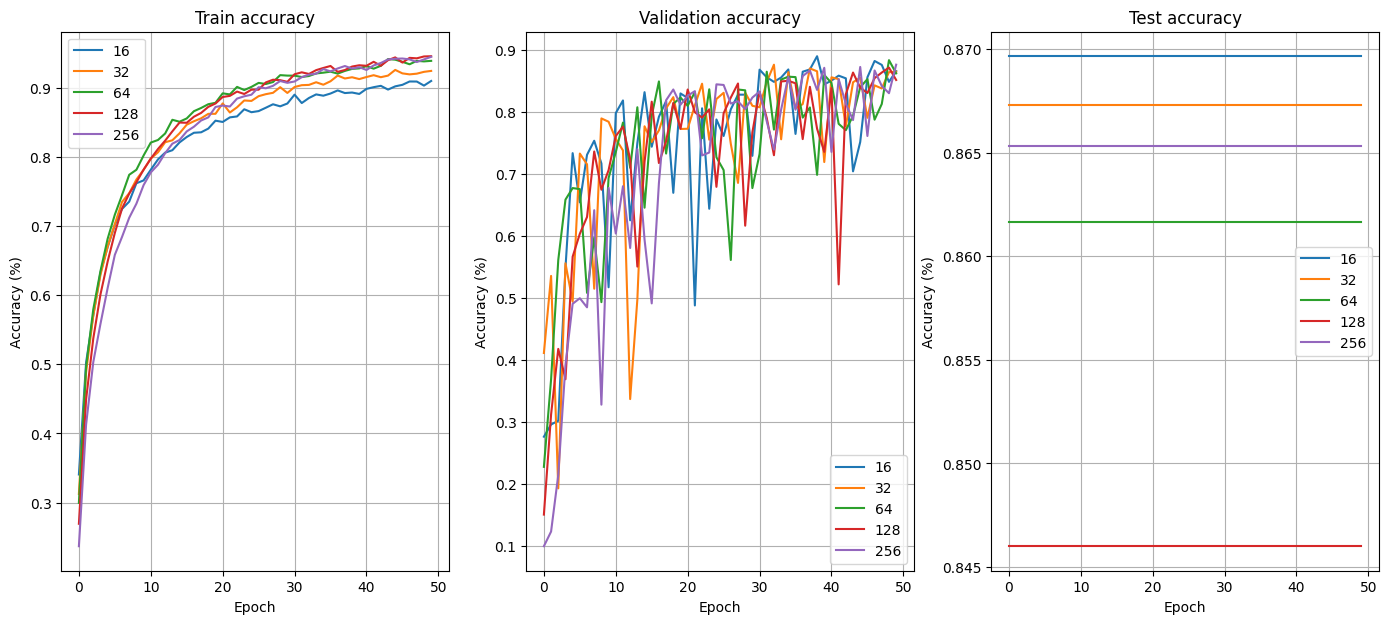

In [ ]:
# plot accuracy results
fig,ax = plt.subplots(1,3,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsVal)
ax[1].set_title('Validation accuracy')
ax[2].plot(accuracyResultsTest)
ax[2].set_title('Test accuracy')

# common features
for i in range(3):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].grid()

plt.show()

Tuning dropout

In [25]:
# Run parametric experiment to tune dropout percentage
def createAndTrain_model_Dropout(dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(31, 31, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train_aug, y_train_aug, validation_data=processed_validation_dataset, epochs=epochs, batch_size=16, shuffle=True)

    # Evaluate model on unseen data
    scores = model.evaluate(X_test, y_test)
    testError = 100-scores[1]*100

    return history, scores, testError

In [26]:
# specify number of hidden units
dropout_percentages = np.arange(0, 1, 0.1)

# initialize results matrix
results = np.zeros((len(dropout_percentages),4))

for i,npercent in enumerate(dropout_percentages):
  history, scores, testError = createAndTrain_model_Dropout(int(npercent))
  results[i,:] = [ history.history['accuracy'][-1], history.history['val_accuracy'][-1], scores[1], testError ]


Epoch 1/50
736/736 [==============================] - 16s 19ms/step - loss: 1.7799 - accuracy: 0.4415 - val_loss: 1.7226 - val_accuracy: 0.4853
Epoch 2/50
736/736 [==============================] - 10s 13ms/step - loss: 1.1201 - accuracy: 0.6460 - val_loss: 1.1212 - val_accuracy: 0.6417
Epoch 3/50
736/736 [==============================] - 10s 14ms/step - loss: 0.8229 - accuracy: 0.7382 - val_loss: 3.3393 - val_accuracy: 0.3373
Epoch 4/50
736/736 [==============================] - 10s 14ms/step - loss: 0.6305 - accuracy: 0.7950 - val_loss: 1.2366 - val_accuracy: 0.6230
Epoch 5/50
736/736 [==============================] - 11s 15ms/step - loss: 0.4786 - accuracy: 0.8442 - val_loss: 3.1803 - val_accuracy: 0.4460
Epoch 6/50
736/736 [==============================] - 10s 13ms/step - loss: 0.3727 - accuracy: 0.8780 - val_loss: 0.9738 - val_accuracy: 0.7167
Epoch 7/50
736/736 [==============================] - 10s 14ms/step - loss: 0.3087 - accuracy: 0.8986 - val_loss: 0.8976 - val_accuracy:

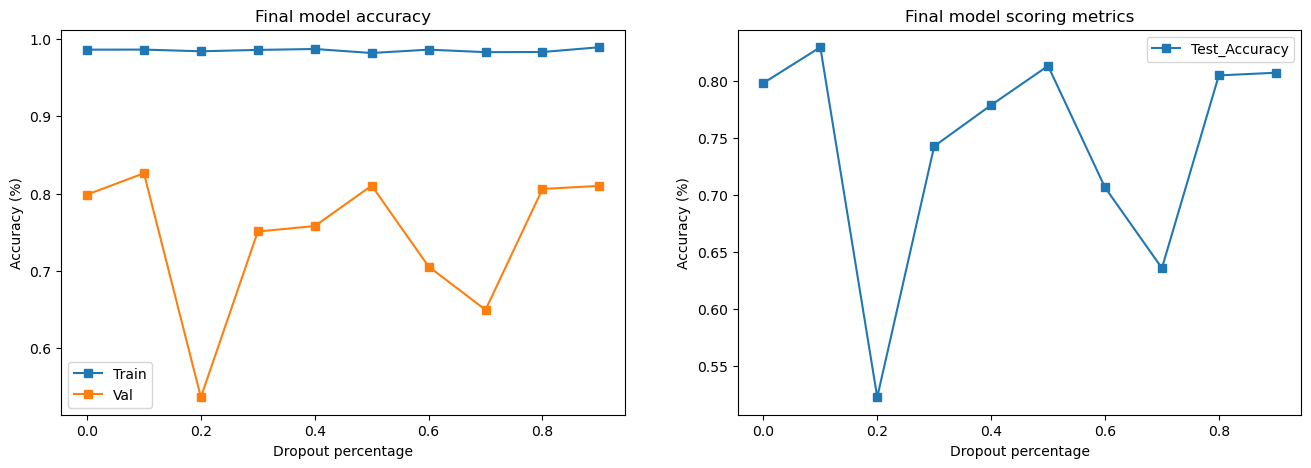

In [27]:
# Plot parametric experiment results
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(dropout_percentages,results[:,:2],'s-')
ax[0].set_xlabel('Dropout percentage')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Final model accuracy')
ax[0].legend(['Train','Val'])

ax[1].plot(dropout_percentages,results[:,2],'s-')
ax[1].set_xlabel('Dropout percentage')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model scoring metrics')
ax[1].legend(['Test_Accuracy'])
# ax[1].set_ylim([0.87, 0.9])

plt.show()

Dropout of 0.3 seems to work best on the dataset

Tuning number of hidden units

In [28]:
# Run parametric experiment to tune number of hidden units on Dense layer
def createAndTrain_model_NumUnits(numUnits):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(31, 31, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(numUnits, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train_aug, y_train_aug, validation_data=processed_validation_dataset, epochs=epochs, batch_size=16, shuffle=True)

    # Evaluate model on unseen data
    scores = model.evaluate(X_test, y_test)
    testError = 100-scores[1]*100

    return history, scores, testError

In [29]:
# specify number of hidden units
numberOfLinearUnits = np.round(np.linspace(5,500,20))

# initialize results matrix
results = np.zeros((len(numberOfLinearUnits),4))

for i,nunits in enumerate(numberOfLinearUnits):
  history, scores, testError = createAndTrain_model_NumUnits(int(nunits))
  results[i,:] = [ history.history['accuracy'][-1], history.history['val_accuracy'][-1], scores[1], testError ]

Epoch 1/50
736/736 [==============================] - 11s 14ms/step - loss: 2.6005 - accuracy: 0.1472 - val_loss: 2.5418 - val_accuracy: 0.1700
Epoch 2/50
736/736 [==============================] - 10s 14ms/step - loss: 2.3167 - accuracy: 0.2421 - val_loss: 2.4513 - val_accuracy: 0.1817
Epoch 3/50
736/736 [==============================] - 10s 14ms/step - loss: 2.1121 - accuracy: 0.2984 - val_loss: 2.2636 - val_accuracy: 0.2517
Epoch 4/50
736/736 [==============================] - 10s 14ms/step - loss: 1.9738 - accuracy: 0.3517 - val_loss: 1.8792 - val_accuracy: 0.3620
Epoch 5/50
736/736 [==============================] - 10s 14ms/step - loss: 1.8342 - accuracy: 0.4037 - val_loss: 2.5831 - val_accuracy: 0.2370
Epoch 6/50
736/736 [==============================] - 10s 14ms/step - loss: 1.7211 - accuracy: 0.4415 - val_loss: 1.8865 - val_accuracy: 0.3657
Epoch 7/50
736/736 [==============================] - 10s 14ms/step - loss: 1.6424 - accuracy: 0.4690 - val_loss: 3.8038 - val_accuracy:

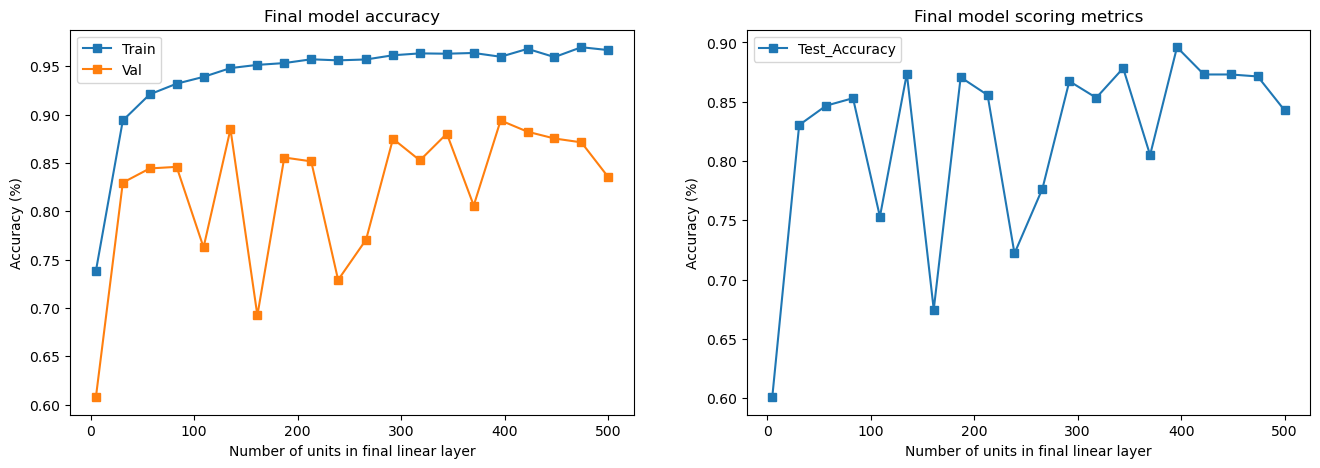

In [30]:
# Plot parametric experiment results
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(numberOfLinearUnits,results[:,:2],'s-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Final model accuracy')
ax[0].legend(['Train','Val'])

ax[1].plot(numberOfLinearUnits,results[:,2],'s-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model scoring metrics')
ax[1].legend(['Test_Accuracy'])
# ax[1].set_ylim([0.87, 0.9])

plt.show()

In [36]:
numberOfLinearUnits

array([  5.,  31.,  57.,  83., 109., 135., 161., 187., 213., 239., 266.,
       292., 318., 344., 370., 396., 422., 448., 474., 500.])

Seems like 396 units in the hidden layer yields the greatest test accuracy (of around 87%)

But, after playing around a little further with other hyperparameters, we get an even higher test accuracy of:

In [24]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)
model_checkpoint_31 = ModelCheckpoint('best_31_CNN_version2.h5', save_best_only = True)

def make_finalModel():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (7, 7), input_shape=(31, 31, 1), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = make_finalModel()
history = model.fit(X_train_aug, y_train_aug, validation_data=processed_validation_dataset, 
                    epochs=epochs, batch_size=16, shuffle=True, callbacks=[monitor_val_acc, model_checkpoint_31])

# Evaluate model on unseen data
scores = model.evaluate(X_test, y_test)
testError = 100-scores[1]*100
print(f'Model test accuracy on 31x31 images: {round(scores[1]*100,2)}%\nModel test error on 31x31 images: {round(testError,2)}%')

Epoch 1/50
734/736 [============================>.] - ETA: 0s - loss: 2.0043 - accuracy: 0.3699

c:\Users\tanyf\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


736/736 [==============================] - 16s 19ms/step - loss: 2.0034 - accuracy: 0.3703 - val_loss: 3.4849 - val_accuracy: 0.1987
Epoch 2/50
736/736 [==============================] - 11s 15ms/step - loss: 1.4108 - accuracy: 0.5417 - val_loss: 1.4861 - val_accuracy: 0.5480
Epoch 3/50
736/736 [==============================] - 10s 14ms/step - loss: 1.1616 - accuracy: 0.6223 - val_loss: 1.4237 - val_accuracy: 0.5757
Epoch 4/50
736/736 [==============================] - 10s 14ms/step - loss: 0.9794 - accuracy: 0.6766 - val_loss: 1.4832 - val_accuracy: 0.5750
Epoch 5/50
736/736 [==============================] - 10s 14ms/step - loss: 0.8319 - accuracy: 0.7299 - val_loss: 1.5422 - val_accuracy: 0.5663
Epoch 6/50
736/736 [==============================] - 10s 14ms/step - loss: 0.7578 - accuracy: 0.7506 - val_loss: 0.7114 - val_accuracy: 0.7767
Epoch 7/50
736/736 [==============================] - 10s 14ms/step - loss: 0.6826 - accuracy: 0.7773 - val_loss: 1.1401 - val_accuracy: 0.6793
Epo

In [61]:
final_model = make_finalModel()
final_model.load_weights('best_31_CNN_version2.h5')
# Re-evaluate the model
loss, acc = final_model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

94/94 - 1s - loss: 0.4116 - accuracy: 0.8813 - 1s/epoch - 12ms/step
Restored model, accuracy: 88.13%


In [73]:
from sklearn.metrics import classification_report
y_pred = final_model.predict(X_test)

report = classification_report(
    np.argmax(tf.keras.utils.to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1), target_names=list(class_names)
)


94/94 [==============================] - 1s 6ms/step


In [77]:
print(report)

              precision    recall  f1-score   support

        Bean       0.87      0.89      0.88       200
Bitter_Gourd       0.93      0.81      0.86       200
Bottle_Gourd       0.95      0.98      0.96       200
     Brinjal       0.88      0.90      0.89       200
    Broccoli       0.86      0.85      0.85       200
     Cabbage       0.76      0.89      0.82       200
    Capsicum       0.90      0.96      0.93       200
      Carrot       0.93      0.90      0.91       200
 Cauliflower       0.85      0.80      0.82       200
    Cucumber       0.94      0.95      0.95       200
      Papaya       0.94      0.91      0.92       200
      Potato       0.83      0.83      0.83       200
     Pumpkin       0.95      0.82      0.88       200
      Radish       0.94      0.91      0.92       200
      Tomato       0.75      0.84      0.80       200

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88   

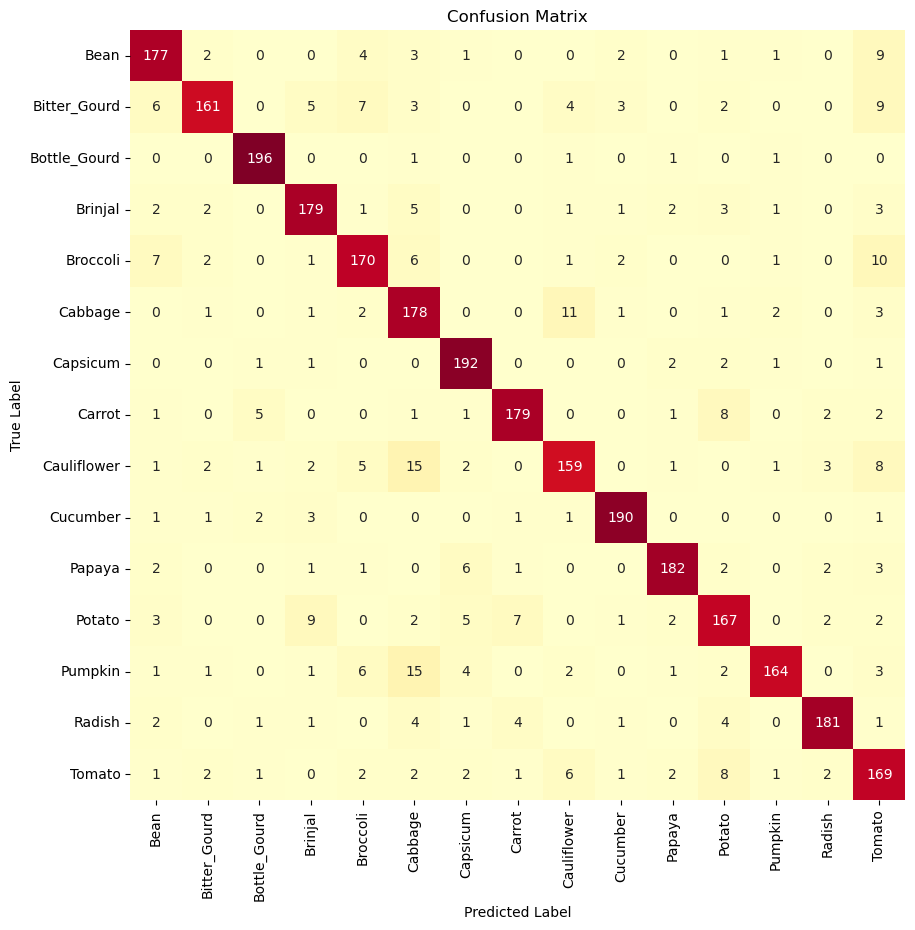

In [78]:
import seaborn as sns
plt.figure(1, figsize=(10, 10))
plt.title("Confusion Matrix")
sns.heatmap(tf.math.confusion_matrix(
    np.argmax(tf.keras.utils.to_categorical(y_test), axis=1),
    np.argmax(y_pred, axis=1),
    num_classes=15,
    dtype=tf.dtypes.int32,
    name=None
), annot=True, fmt="", cbar=False, cmap="YlOrRd", yticklabels=list(class_names), xticklabels=list(class_names))
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [26]:
# summarize filter shapes
for layer in final_model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_2 (7, 7, 1, 64)
conv2d_3 (5, 5, 64, 64)


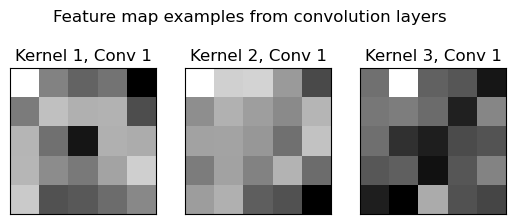

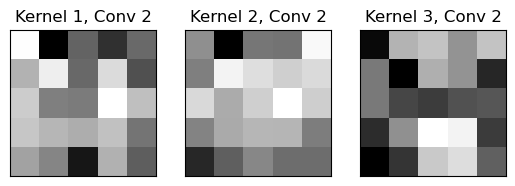

In [27]:
# plot first few filters
n_filters, ix = 2, 1
plt.suptitle(f'Feature map examples from convolution layers')
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Kernel {j+1}, Conv {i+1}')
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
    # show the figure
    plt.show()